## Annotator Model

Supervised learning algorithms rely on labelled data. The labels are generated by human annotators that have varying degrees of expertise in labeling the data. The Dawid-Skene annotator model [1] recovers true item labels from noisy annotator input in addition to quantifying the accuracy of annotators. The graphical model for the annotator model is shown below.

<img src="figures/annotator_gm.png">

In this model we have $I$ items that belong to $K$ classes and $J$ annotators whose task is to label each item class. The generative model can be described as follows:

\begin{eqnarray}
    \pi \sim \mathrm{Dir}(\alpha) \\
    \theta_j \sim \mathrm{Dir}(\beta) \\
    z_i \sim \mathrm{Cat}(\pi) \\
    y_i \sim \mathrm{Cat}(\theta_{j, z[i]})
\end{eqnarray}

Here $\alpha$ is a Dirichlet prior on class distributions, $\beta$ is a Dirichlet prior on annotator accuracy expressed as a confusion matrix. The observations $y_i$ consist of (item, annotator, label) tuple. We can use the ground truth labels to evaluate annotation accuracy by looking at the confusion matrix. In addition, we can compare our probabilistic graphical model solution with a simple majority vote baseline.

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import pymc3 as pm

In [5]:
#load data    
data = np.load('./data/extrahard_MC_500_5_4.npz.npy')
z_true = np.load('./data/extrahard_MC_500_5_4_reference_classes.npy')

In [6]:
I = data.shape[0]               # number of items
J = data.shape[1]               # number of annotators
K = data.shape[2]               # number of classes
N = I * J

In [8]:
# create data triplets
jj = list()  # annotator IDs
ii = list()  # item IDs
y = list()   # response

# initialize true category with majority votes
z_init = np.zeros(I, dtype=np.int64)

# create data triplets
for i in range(I):
     ks = list()
     for j in range(J):
        dat = data[i,j,:]
        k = np.where(dat == 1)[0][0]
        ks.append(k)
        ii.append(i)
        jj.append(j)
        y.append(k)

     # getting maj vote for work item i
     z_init[i] = np.bincount(np.array(ks)).argmax()
#end for

majority vote baseline: 
[[120   2   1   2]
 [  5 116   4   0]
 [  4   6 113   2]
 [  4   3   3 115]]


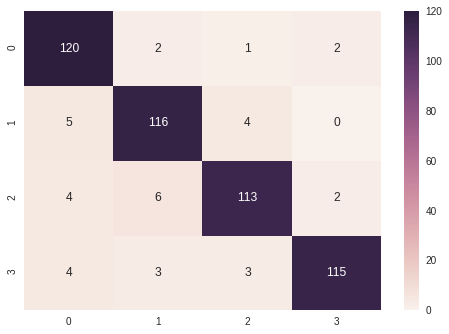

In [9]:
confMat = confusion_matrix(z_true, z_init)
print "majority vote baseline: \n", confMat
df_cm1 = pd.DataFrame(confMat)
sns.heatmap(df_cm1, annot=True,  fmt='d')
plt.show()

The above confusion matrix shows the correctly classified items based on majority vote along the main diagonal as well mislabeled clases in the off-diagonal entries for $K=4$ classes for $I=500$ items and $J=5$ annotators. We'll come back to this confusion matrix when we compare our probabilistic solution agains the majority vote baseline.

In [10]:
#class prior
alpha = np.ones(K)
    
# individual annotator confusion matrices - dominant diagonal
beta = np.ones((K,K)) + np.diag(np.ones(K))
    
with pm.Model() as model:
        
    pi = pm.Dirichlet('pi', a=alpha, shape=K)
    theta = pm.Dirichlet('theta', a=beta, shape=(J,K,K))
    z = pm.Categorical('z', p=pi, shape=I, testval=z_init)
    y_obs = pm.Categorical('y_obs', p=theta[jj,z[ii]], observed=y)

In [11]:
with model:
    step1 = pm.Metropolis(vars=[pi,theta])
    step2 = pm.CategoricalGibbsMetropolis(vars=[z])
    trace = pm.sample(5000, step=[step1, step2], progressbar=True)

100%|██████████| 5500/5500 [30:02<00:00,  3.05it/s]


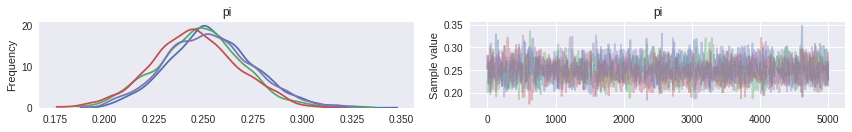

In [12]:
pm.traceplot(trace, varnames=['pi'])
plt.show()

The $\pi$ trace above shows that there is an equal presence of classes in the dataset. To compute posterior labels we take $1000$ most recent samples of label assignments $z$, compute a histogram and take the maximum value.

In [13]:
#majority vote of posterior samples
z = trace['z'][-1000:,:]
z_hat = np.zeros(I)
for i in range(I):
    z_hat[i] = np.bincount(z[:,i]).argmax()

majority vote posterior: 
[[122   1   2   0]
 [  1 119   3   2]
 [  1   3 119   2]
 [  2   4   2 117]]


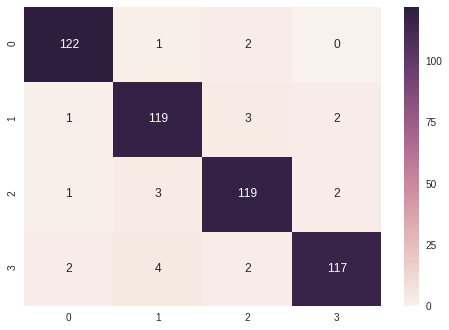

In [14]:
confMat2 = confusion_matrix(z_true, z_hat)
print "majority vote posterior: \n", confMat2     
df_cm2 = pd.DataFrame(confMat2)
sns.heatmap(df_cm2, annot=True,  fmt='d')
plt.show()

We can see that the probabilistic model yielded higher label accuracy by comparing diagonal entries of the confusion matrix with majority vote baseline. In addition, we can view the posterior distribution of the annotators accuracy.

In [28]:
#posterior quality of annotators
np.set_printoptions(precision=2)
acc = np.zeros(J)
for j in range(J):
    print( "Annotator j=" + str(j) )
    Cj = trace['theta'][-1,j]
    acc[j] = np.trace(np.array(Cj.tolist()))/float(np.sum(np.array(Cj.tolist())))
    print(Cj)

Annotator j=0
[[ 0.87  0.03  0.09  0.01]
 [ 0.    0.95  0.01  0.03]
 [ 0.06  0.02  0.9   0.01]
 [ 0.01  0.01  0.02  0.96]]
Annotator j=1
[[ 0.69  0.08  0.14  0.09]
 [ 0.14  0.68  0.12  0.07]
 [ 0.09  0.15  0.69  0.08]
 [ 0.14  0.14  0.1   0.62]]
Annotator j=2
[[ 0.59  0.14  0.15  0.11]
 [ 0.18  0.44  0.21  0.17]
 [ 0.17  0.03  0.61  0.19]
 [ 0.09  0.12  0.15  0.65]]
Annotator j=3
[[ 0.64  0.17  0.11  0.08]
 [ 0.04  0.77  0.04  0.15]
 [ 0.05  0.11  0.75  0.09]
 [ 0.08  0.07  0.15  0.7 ]]
Annotator j=4
[[ 0.56  0.16  0.13  0.15]
 [ 0.15  0.48  0.24  0.13]
 [ 0.14  0.15  0.55  0.16]
 [ 0.21  0.1   0.13  0.56]]


From the posterior confusion matrix, we can evaluate annotator accuracy.

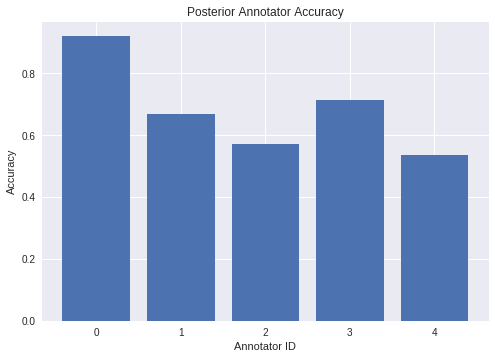

In [30]:
plt.figure()
plt.bar(range(J), acc)
plt.title("Posterior Annotator Accuracy")
plt.xlabel("Annotator ID")
plt.ylabel("Accuracy")
plt.show()

**References**
1. P. Dawid and A. M. Skene, "Maximum likelihood estimation of observer error-rates using the EM algorithm", Applied Statistics, 1979
2. R. Passonneau and B. Carpenter, "The benefits of a model of annotation", TACL, 2014